# Patchouris analysis notebook
'''Documentation about the task here'''

### Imports  
All functions are in behavior_analysis_functions.py

In [4]:
from behavior_analysis_functions import *


### Get mice data
Define root, get mice list and session for each mouse

In [14]:
# Root of all mice data
# root: str = 'C:'+os.sep+'Users'+os.sep+'MORVAN'+os.sep+'Documents'+os.sep+'patchouris'+os.sep+'Sample_Data'+os.sep
root: str = '/home/david/MyLocalData/Maud/'

# List all mice in the root folder
mouse_list: list[str] = [os.path.basename(path) for path in glob.glob(root+"/MOU*")]
print(f'Found {len(mouse_list)} {"mice" if len(mouse_list)>1 else "mouse"} in the root folder:')

session_list: dict[str, list[str]] = {}
for mouse in mouse_list:
    mouse_folder = root + mouse
    session_list[mouse] = [name for name in os.listdir(mouse_folder)
                            if os.path.isdir(os.path.join(mouse_folder, name))
                            and name.startswith('MOU')]
    nb_sessions: int = len(session_list[mouse])
    print(f'{MOUSE_STRING}  ~Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions.')
    print(session_list[mouse], '\n')

mouse_list: list[str] = ["MOU4437_2"] 

In [7]:
def figure_trajectoriesMaud(df, current_movement, xgauss, ygauss, speed, angular_speed, acceleration, title='', ax1=None):
    if ax1 is None:
        _, ax1 = plt.subplots(1, 1, figsize=(5, 5))


    for patch in collection_trapeze:  #plot the trapeze around the object
        for trapeze in collection_trapeze[patch]:
            shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color="lemonchiffon")
            ax1.add_patch(shape)
        for u in current_movement:  #plot each individual trajectory of the current category
            colors = plt.cm.rainbow(np.random.random())
            if len(u) != 0:
                ax1.plot(xgauss[u[0]:u[1]], ygauss[u[0]:u[1]], lw=0.5, c=colors)
            else:
                pass

    #Plots a colored dot at the begining and end of each epoch
    indices_start = [u[0] for u in current_movement]
    indices_end = [u[1] for u in current_movement]
    if len(indices_start) != 0 or len(indices_end) != 0:
        ax1.scatter(xgauss[indices_start], ygauss[indices_start], linewidths=0.1, color="green")
        ax1.scatter(xgauss[indices_end], ygauss[indices_end], linewidths= 0.1, color="red")
    else:
        pass

    timeSpentIn = round(sum([df.loc[df.index[epoch[1]], 'time'] - df.loc[df.index[epoch[0]], 'time'] for epoch in current_movement]), 2)

    #Sets the parameters of the graph
    ax1.set_ylim(0, 500)
    ax1.set_xlim(0, 500)
    ax1.set_title(title + str(len(current_movement)) + f"\n total time: {timeSpentIn}s")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

In [13]:
mouseFolder_Path=root+mouse
# Load the data
df, turns_df, session_params = load_data(mouseFolder_Path, session)
phase, direction, cno = get_phase_direction_cno(session_params)

###############################################################################
###############################################################################
# unpack the data
size_of_df = len(df) #Gets some informations in a more convenient form
time = df['time'].to_numpy()
xposition = df['xposition'].to_numpy()
yposition = df['yposition'].to_numpy()
yposition = RESOLUTION[1] - yposition #yposition is inverted, puts it back in the right way
xgauss = smooth(xposition, TRUE_SIGMA)
ygauss = smooth(yposition, TRUE_SIGMA) #Smoothes the positions with true sigma

#Does the actual analysis. The remaining part consists in accessing the pertinent informations and plotting them
distance, speed, time_average, acceleration, angles, angular_speed, list_epochs = analysis_trajectory(
    time, xgauss, ygauss, collection_trapeze, turns_df, TRUE_CUT_SPEED, TRUE_ECART_ANGLE, RESOLUTION,
    MIN_DURATION_EPOCH=MINIMAL_DURATION_EPOCH, MIN_DURATION_STOP=MINIMAL_DURATION_STOP)

#prepare lists of epochs corresponding to diffrent type of behavior
stops_type = {"rewarded":[], "unrewarded":[]}
for i in range(len(list_epochs) - 1):
    if list_epochs[i][2][0] == "Q": #If this is a quarter turn
        if list_epochs[i][2][2] == "G": #If this is a good turn and thus a rewarded quarter turn
            stops_type["rewarded"].append([list_epochs[i][1], list_epochs[i + 1][0]])
        else: #Then the quarter turn was not rewarded
            stops_type["unrewarded"].append([list_epochs[i][1], list_epochs[i + 1][0]])
    #elif list_epochs[i][2][0] == "B": #If this is a between objects
    #    if list_epochs[i][2][5] == 'r': #If the trajectory was rewarded
    #        stops_type["rewarded"].append([list_epochs[i][1], list_epochs[i + 1][0]])
    #    else: #Then the between objects was unrewarded
    #        stops_type["unrewarded"].append([list_epochs[i][1], list_epochs[i + 1][0]])

list_quarter_turn = [epoch for epoch in list_epochs if epoch[2][0] == "Q"] #Gets the list of all quarter turns
list_between_objects = [epoch for epoch in list_epochs if epoch[2][0] == "B"] #Gets all trajectories between objects
list_toward_object = [epoch for epoch in list_epochs if epoch[2][0] == "T"] #Gets all trajectories towards objects
list_movement_not_quarter = [epoch for epoch in list_epochs if epoch[2][0] == "N"] #Gets all explorative trajectories
list_of_stops = [[list_epochs[a - 1][1 ] + 1, list_epochs[a][0] - 1] for a in range(1, len(list_epochs))]

#Creates a list for each type of quarter turn
rewarded = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'G']
unrewarded = [epoch for epoch in list_quarter_turn if epoch[2][2] != 'G']
extra = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'E']
badDirection = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'B']
wrongObject = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'O']
doubleWrong = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'H']

# between_reward = [epoch for epoch in list_between_objects if epoch[2][5] == 'r']
# between_unrewarded = [epoch for epoch in list_between_objects if epoch[2][5] == 'n']

anti_clock_turn = [epoch for epoch in list_quarter_turn if epoch[2][1] == "k"]
clock_turn = [epoch for epoch in list_quarter_turn if epoch[2][1] == "w"]
exploring = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'X']

when_reward = [[turns_df.loc[a, "time"], turns_df.loc[a, "currentPatch"]] for a in turns_df.index if turns_df.loc[a, "Rewarded"]]
when_no_reward = [[turns_df.loc[a, "time"], turns_df.loc[a, "currentPatch"]] for a in turns_df.index if not turns_df.loc[a, "Rewarded"]]

######################################################
# Figure creation  ~10sec
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

figure_trajectoriesMaud(df, list_quarter_turn, xgauss, ygauss, speed, angular_speed, acceleration, "Quarter turns: ", ax1=ax)

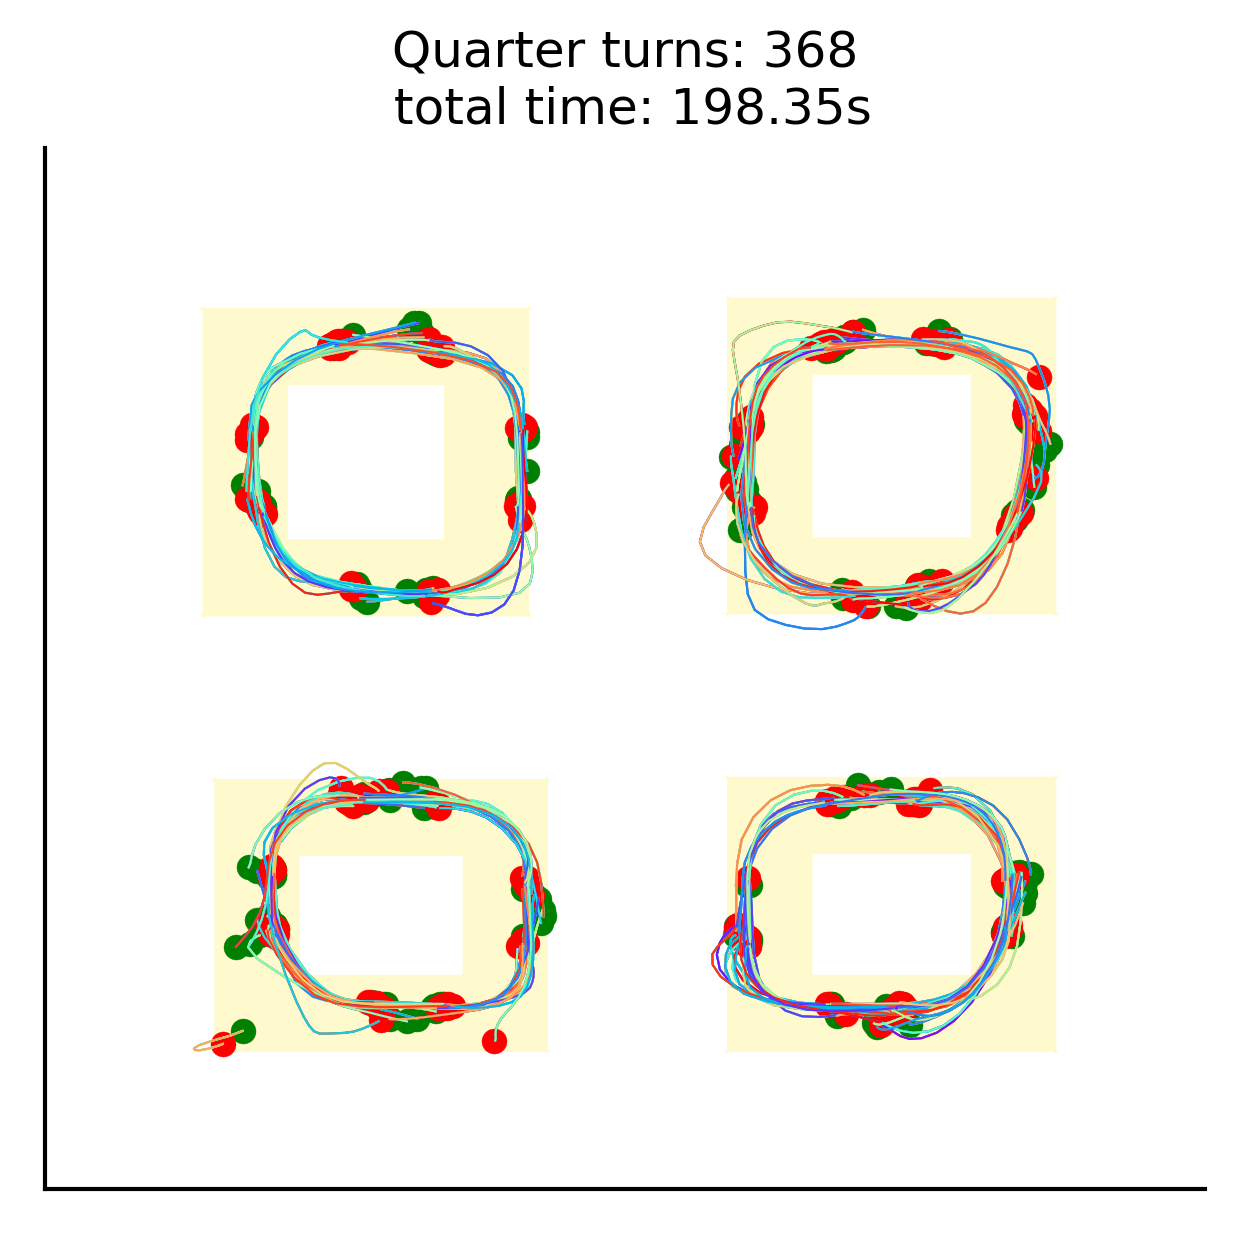

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

figure_trajectoriesMaud(df, list_quarter_turn, xgauss, ygauss, speed, angular_speed, acceleration, "Quarter turns: ", ax1=ax)